In [1]:
import numpy as np
import matplotlib.pyplot as plt
from cvxopt import matrix as cvxopt_matrix
from cvxopt import solvers as cvxopt_solvers
from sklearn.datasets import make_moons

In [2]:

def kernel(X1, X2, scale=1.0, sigma_f=1.0):
    ''' Uncomment for Gaussian Kernel '''
    sqdist = np.sum(X1**2, 1).reshape(-1, 1) + np.sum(X2**2, 1) - 2 * np.dot(X1, X2.T)
    return sigma_f**2 * np.exp((-0.5 / scale**2) * sqdist)
#    ''' Uncomment for Linear Kernel '''
#    return X1 @ X2.T
def dataSet2():
    X, y = make_moons(n_samples=100, noise=0.1)
    y = np.where(y==0, -1, y)
    y = y.reshape(-1,1)
    S = (y>0).squeeze()
    x_pos = X[S]
    x_neg = X[np.invert(S)]
    return X,y,x_pos,x_neg

In [9]:
def dualOptimizer_hardmargins(H,m,y):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(-np.eye(m))
    h = cvxopt_matrix(np.zeros(m))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas

def dualOptimizer_softmargins(H,m,y,C):
    '''Converting the parameters to standard format for the optimizer function cvxopt_solvers.qp(P, q, G, h, A, b)'''
    H = H*1.0   # Multiply 1.0 to convert all values into float
    y = y*1.0   # Multiply 1.0 to convert all values into float
    P = cvxopt_matrix(H)
    q = cvxopt_matrix(-np.ones((m, 1)))
    G = cvxopt_matrix(np.vstack((-np.eye((m)), np.eye(m))))
    h = cvxopt_matrix(np.vstack((np.zeros((m,1)), np.ones((m,1)) * C)))
    A = cvxopt_matrix(y.reshape(1, -1))
    b = cvxopt_matrix(np.zeros(1))
    
    #Setting solver parameters (change default to decrease tolerance) 
    cvxopt_solvers.options['show_progress'] = False
    cvxopt_solvers.options['abstol'] = 1e-10
    cvxopt_solvers.options['reltol'] = 1e-10
    cvxopt_solvers.options['feastol'] = 1e-10
    
    #Run solver
    sol = cvxopt_solvers.qp(P, q, G, h, A, b)
    alphas = np.array(sol['x'])
    return alphas


def pred(y,a,X,p,b):
    k = kernel(X,p)
    return (y * a).T @ k +b
    
def predb(y,a,X,p):    
    k = kernel(X,p)
    xc = (y * a).T @ k
    print(k.shape,xc.shape)
    return np.average(y.T-xc)

In [10]:
''' Implementing SVM hard margin '''
'''Converting second term of dual objective function into standard form, a.T*H*a for the optimizer'''
X,y,x_pos,x_neg = dataSet2()
k = kernel(X,X)
t = np.dot(y,y.T)
H = k*t              
m,n = X.shape
C=10000  #Taking C to be 10000 in the constraint. For a higher value of C we get a more stricter margin for the dataset as seen in the observation below 
alphas_hard = dualOptimizer_hardmargins(H,m,y)
alphas_soft = dualOptimizer_softmargins(H,m,y,C)
#Selecting the set of indices S corresponding to non zero parameters
S = (alphas_hard > 1e-4).flatten()
S1= (alphas_soft > 1e-4).flatten()
w = ((y[S] * alphas_hard[S]).T @ X[S]).reshape(-1,1)
w1= ((y[S] * alphas_soft[S]).T @ X[S]).reshape(-1,1)
#Computing b
b = predb(y[S],alphas_hard[S],X[S],X[S])
b1= predb(y[S],alphas_soft[S],X[S],X[S])

#Display results
print('Alphas for hard margins: ',alphas_hard,'\n Support Vectors: ',S.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_hard[alphas_hard > 1e-4])
print('w = ', w.flatten())
print('b = ', b)

(7, 7) (1, 7)
(7, 7) (1, 7)
Alphas for hard margins:  [[4.03318140e+01]
 [8.09382328e-11]
 [3.65297010e-11]
 [1.70806710e-10]
 [2.36386126e-11]
 [5.31455971e-11]
 [2.87483941e-11]
 [3.58539466e-11]
 [1.53694237e-10]
 [6.26710312e-11]
 [4.39961143e-11]
 [1.90562076e-10]
 [4.87487445e-11]
 [2.69847952e+01]
 [8.39436325e-11]
 [3.87136255e-11]
 [4.53095252e-11]
 [6.07423562e-11]
 [2.79090003e-11]
 [6.85307356e-11]
 [4.82234019e-11]
 [2.96723017e-11]
 [6.13171014e-11]
 [3.65270580e-11]
 [4.94578376e-11]
 [5.46336600e-11]
 [3.21470251e-11]
 [7.24543542e-11]
 [2.22806101e-10]
 [1.68039643e+01]
 [4.07465306e-11]
 [4.83491140e-11]
 [3.24811556e-11]
 [3.80447051e-11]
 [2.67941068e-11]
 [3.29021992e-11]
 [7.86321344e-11]
 [1.13416487e-10]
 [2.90450467e-11]
 [4.82338067e-11]
 [3.74989910e-11]
 [4.13067330e-11]
 [4.77031147e-11]
 [9.21217635e-11]
 [2.82017678e-11]
 [3.11646071e-11]
 [3.30755414e-11]
 [1.18693416e-10]
 [4.99296521e-11]
 [5.23924817e-11]
 [4.17483554e-11]
 [2.85530446e-11]
 [2.181965

In [11]:
print('Alphas for soft margins: ',alphas_soft,'\n Support Vectors: ',S1.reshape(-1,1))
print('Alphas for Support Vectors = ',alphas_soft[alphas_soft > 1e-4])
print('w = ', w1.flatten())
print('b = ', b1)

Alphas for soft margins:  [[4.03318140e+01]
 [4.57888098e-11]
 [2.35314794e-11]
 [1.21022307e-10]
 [1.53995709e-11]
 [2.96294254e-11]
 [1.85949024e-11]
 [2.12992636e-11]
 [8.41254904e-11]
 [3.89829132e-11]
 [2.49805642e-11]
 [8.49012121e-11]
 [3.18800312e-11]
 [2.69847952e+01]
 [5.17202416e-11]
 [2.42795269e-11]
 [2.74028432e-11]
 [3.58495175e-11]
 [1.64037573e-11]
 [4.04471136e-11]
 [3.00562368e-11]
 [1.72060135e-11]
 [5.03647682e-11]
 [2.27615070e-11]
 [3.09965890e-11]
 [3.65528355e-11]
 [1.93347187e-11]
 [4.51066808e-11]
 [4.89878701e-11]
 [1.68039643e+01]
 [2.33274059e-11]
 [2.94299976e-11]
 [2.05469489e-11]
 [2.51228905e-11]
 [1.70936060e-11]
 [2.12304315e-11]
 [4.32097224e-11]
 [6.84377010e-11]
 [1.73163815e-11]
 [3.02966625e-11]
 [2.17772620e-11]
 [2.42888829e-11]
 [3.06800150e-11]
 [5.15838950e-11]
 [1.77944057e-11]
 [2.01411429e-11]
 [2.23676448e-11]
 [7.42824219e-11]
 [3.01218165e-11]
 [3.47618180e-11]
 [2.36727809e-11]
 [1.80742742e-11]
 [4.69767614e-11]
 [3.81329995e-11]
 [

<a list of 4 text.Text objects>

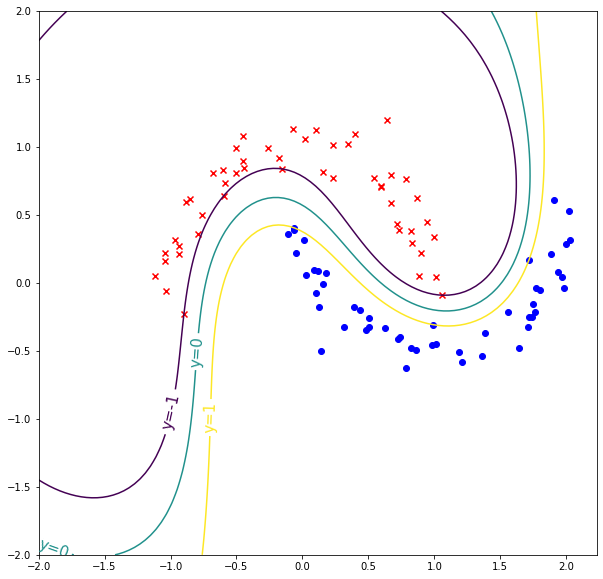

In [12]:
fig = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x0, x1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p = np.array([x0, x1]).reshape(2, -1).T
pr = pred(y[S],alphas_hard[S],X[S],p,b)
#print(pr)
'''hardmargin hyperplanes'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp = plt.contour(x0, x1, pred(y[S],alphas_hard[S],X[S],p,b).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp, fmt='y=%.f', inline=True, fontsize=15)

<a list of 4 text.Text objects>

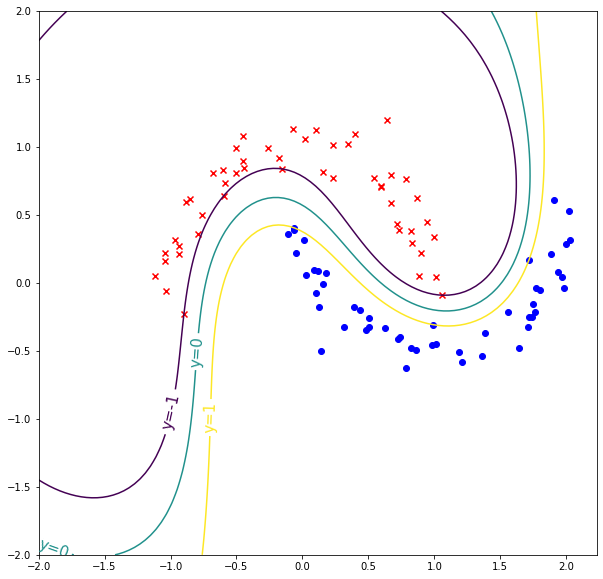

In [13]:
fig1 = plt.figure(figsize = (10,10))


'''Prediction for p matrix '''
x_0, x_1 = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
p1 = np.array([x_0, x_1]).reshape(2, -1).T
pr1 = pred(y[S],alphas_soft[S],X[S],p1,b1)
#print(pr)
'''softmargin hyperplanes for C=10000'''

plt.scatter(x_neg[:,0], x_neg[:,1], marker = 'x', color = 'r', label = 'Negative -1')
plt.scatter(x_pos[:,0], x_pos[:,1], marker = 'o', color = 'b',label = 'Positive +1')


cp1 = plt.contour(x_0, x_1, pred(y[S],alphas_soft[S],X[S],p1,b1).reshape(100, 100), np.array([-1, 0, 1]))
plt.clabel(cp1, fmt='y=%.f', inline=True, fontsize=15)